In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unityvr.analysis.waveSurferAnalysis as ws
import fly2p
from ScanImageTiffReader import ScanImageTiffReader
import json
from os.path import sep, exists
from os import mkdir, makedirs, getcwd
from skimage import data
import napari
import xarray as xr
from matplotlib.animation import FuncAnimation

from unityvr.preproc import logproc as lp
from unityvr.viz import viz
from unityvr.analysis import posAnalysis, shapeAnalysis, fitting, utils

from fly2p.viz.viz import myAxisTheme, plotDFFheatmap
import fly2p.preproc.imgPreproc as imp
from fly2p.preproc.scanImageUtils import getSIbasicMetadata, getSIMetadict, loadvolume

In [2]:
dirName = '/Volumes/jayaramanlab/Chad/Brad_slip/'
h5fileName = 'wavesurfer_0002.h5'
jsonfileName = 'Log_2024-10-15_16-20-03.json'
#tifffileName = '8min_trial_00001.tif'
playbackfileName = 'sceneArr.nc'
fictracfileName = 'fictrac-20241015_155709.dat'

trial = 'test'
genotype = 'SS-x-GCaMP8s'
flyID = 'cFly00001'
region = 'FB6a'

In [75]:
FTDf = pd.read_csv(sep.join([dirName, fictracfileName]), delimiter=',')
intTheta = FTDf.iloc[:, 16]
deltaTheta = FTDf.iloc[:, 7]
deltaX = FTDf.iloc[:,5]
deltaY = FTDf.iloc[:,6]
intX = FTDf.iloc[:,19]
intY = FTDf.iloc[:,20]
testX = np.cumsum(deltaX)
testY = np.cumsum(deltaY)
testTheta = (np.cumsum(deltaTheta) % np.pi*2)


correcting for Unity angle convention.
No fictrac signal was recorded.
Metadata:

expid  :  testExp
experiment  :  test experiment
genotype  :  testGenotype
sex  :  NA
flyid  :  NA
trial  :  trial6-20-03
date  :  2024-10-15
time  :  16-20-03
ballRad  :  0.04600000008940697
setFrameRate  :  120
notes  :  NA
angle_convention  :  right-handed
dc2cm: 10


KeyError: 'frame'

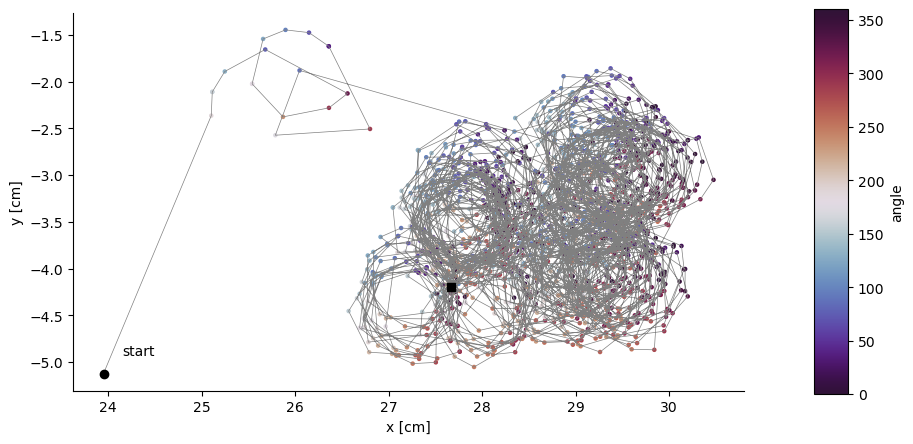

In [143]:
uvrTest = lp.constructUnityVRexperiment(dirName,jsonfileName)
uvrTest.printMetadata()
posDf = posAnalysis.position(uvrTest, derive = True, rotate_by=90, plot=True)
slipDf = posAnalysis.slip_position(uvrTest)
posDf = pd.merge(posDf, slipDf, on='frame', how='left')

In [4]:
saveDir = sep.join([dirName, trial, 'Figures'])
preprocDir = sep.join([dirName, trial, 'PreprocData'])
# Generate directory where to save plots
if not exists(saveDir): makedirs(saveDir)
if not exists(preprocDir): makedirs(preprocDir)

uvrTest = lp.constructUnityVRexperiment(dirName,jsonfileName)
uvrTest.printMetadata()

wsDf = ws.importWaveSurfer(dirName, h5fileName)

counts_2p, diffs_2p, diffs_idx_2p = ws.count_volumes(wsDf['2P Frame Clock'], clock = '2p')
counts_UVR, diffs_UVR, diffs_idx_UVR = ws.count_volumes(wsDf['Arena Frame Clock'], clock = 'arena')

playback = xr.open_dataset(sep.join([dirName, playbackfileName]), engine='netcdf4')

posDf = posAnalysis.position(uvrTest, derive = True, rotate_by=90, plot=True)
alignDf = ws.align_UVR_and_2p(diffs_idx_UVR, diffs_idx_2p, fpv=16)


correcting for Unity angle convention.
No fictrac signal was recorded.
Metadata:

expid  :  testExp
experiment  :  test experiment
genotype  :  testGenotype
sex  :  NA
flyid  :  NA
trial  :  trial5-29-31
date  :  2024-10-15
time  :  15-29-31
ballRad  :  0.04500000178813934
setFrameRate  :  120
notes  :  NA
angle_convention  :  right-handed


OSError: The file /Volumes/jayaramanlab/Chad/Brad_slip/wavesurfer_0002.h5 does not exist.

In [10]:
mytiffreader = ScanImageTiffReader(dirName + tifffileName)
basicMetadat = getSIbasicMetadata(mytiffreader.metadata())
basicMetadat["CaCh"] = 1 # give channel identity
SImetadict = getSIMetadict(mytiffreader.metadata())


SI.VERSION_COMMIT = '5066720ab90fa5f9bfc89c972f39266d0afd7c49'
SI.VERSION_MAJOR = 2022
SI.VERSION_MINOR = 1
SI.VERSION_UPDATE = 0


In [11]:
stack = loadvolume(sep.join([dirName, tifffileName]), basicMetadat, selectCaChan=True)
imgStack = imp.stack2xarray(stack, basicMetadat)

In [13]:
imgStack.to_netcdf(sep.join([preprocDir, 'rawF_stack.nc']))

In [14]:
override = True

/var/folders/cn/txbgqhq90h76btlrfqr0wz7w0000gn/T/ipykernel_75766/1896138822.py:18: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


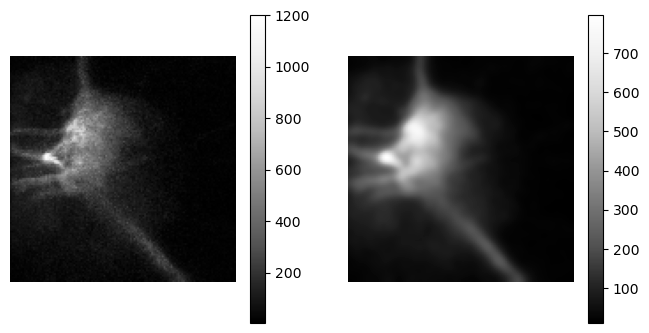

In [15]:
# Set reference image
stackMP = np.max(imgStack, axis=1) # max projection over volume

numRefImg = 20
refstart = 100
locRefImg = round(stackMP['volumes [s]'].size/2)


# Generate reference image
if not exists(sep.join([dirName, 'refImg.npy'])) or override:
    refImg = np.mean(stackMP[locRefImg:locRefImg+numRefImg,:,:],axis=0) #+ np.mean(stackMP[refstart:refstart+numRefImg,:,:],axis=0)
    np.save(sep.join([dirName, 'refImg.npy']), refImg)
else:
    refImg = np.load(sep.join([dirName, 'refImg.npy']))
    refImg = xr.DataArray(refImg)


from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
im = axs[0].imshow(refImg,cmap='Greys_r', origin='lower'); axs[0].axis('off');
fig.colorbar(im, ax=axs[0], orientation='vertical')
im = axs[1].imshow(refImgFilt,cmap='Greys_r', origin='lower'); axs[1].axis('off');
fig.colorbar(im, ax=axs[1], orientation='vertical')

perform motion correction on a single plane/max projection
. . . . . . . . . . . . . . . . . . . . 

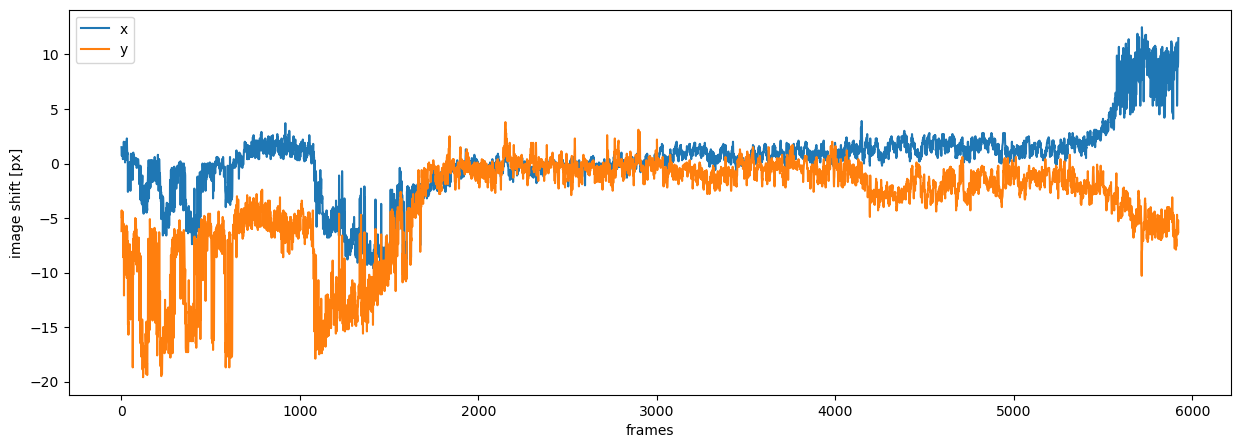

In [16]:
# If there are unreasonable shifts select "doFilter=True".

shift = imp.computeMotionShift(stackMP, refImg, 10, 2, doFilter=False, stdFactor=4, showShiftFig=True)
stackMPMC = imp.motionCorrection(stackMP, shift)

rawF = imp.stack2xarray(stackMPMC, basicMetadat, data4D = False)
rawF.to_netcdf(sep.join([preprocDir, 'rawF_maxprojected_motioncorrected.nc']))

## Compute DFF

In [17]:
## Settings
# settings for Savitzky-Golay filter (default: 3rd order, 7 frames)
order = 3
window = 7

# Currently F_0 is estimated for each pixel on the whole time series (ok, if time series is short)
baseLinePercent = 10
offset = 0.0001

***Specify region for background subtraction***
* Paint a small region named "background" using a brush in the Labels menu in the napari gui. This region should not overlap with the intended signal roi.
* If there is an existing mask placed in the preprocessing folder of the fly and/or tiral, it will be loaded automatically
* If subtracting using rolling ball, skip the next 2 cells

In [18]:
# you can draw a mask on the foreground
viewer = napari.view_image(stackMPMC.mean(axis=0), contrast_limits=[stackMPMC.data.mean(axis=0).min(),np.percentile(stackMPMC.mean(axis=0), 99.9)])

if exists(sep.join([dirName,'background_3d.npy'])):
   background = np.load(sep.join([dirName,'background_3d.npy'])) 
   viewer.add_labels(background, name='background')

2024-10-08 13:07:50.669 python3[75766:2674903] +[IMKClient subclass]: chose IMKClient_Legacy
2024-10-08 13:07:50.669 python3[75766:2674903] +[IMKInputSession subclass]: chose IMKInputSession_Legacy
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


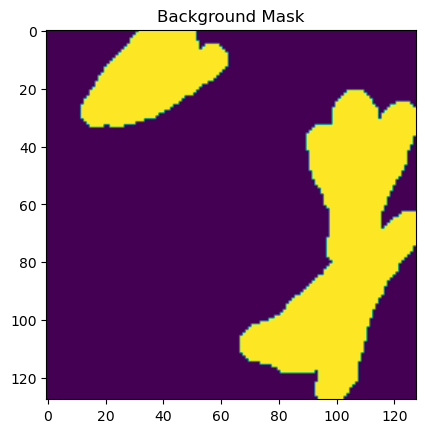

In [19]:
background = viewer.layers["background"].data

np.save(sep.join([dirName,'background_3d']), background)
viewer.close()

plt.imshow(background);
plt.title("Background Mask");

In [20]:
dffStack, stackF0 = imp.computeDFF(stackMPMC, order, window, baseLinePercent, offset, subtract=True, background_mask = background)
dffXarray = imp.stack2xarray(dffStack, basicMetadat, data4D = False)
F0Xarray = imp.refStack2xarray(stackF0, basicMetadat, data4D = False)

processing 3d stack


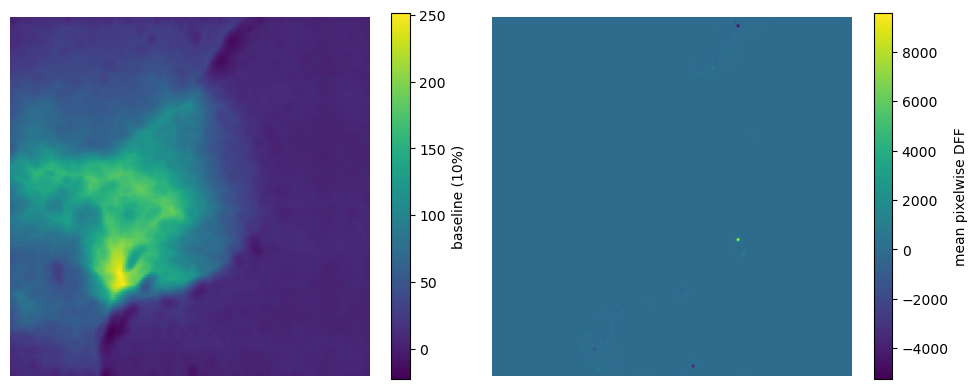

In [21]:
dffMP = np.mean(dffStack,axis=0)
fig, ax = plt.subplots(1,2,figsize=(10,4))
cb = ax[0].imshow(stackF0,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[0], label='baseline ({}%)'.format(baseLinePercent))
ax[0].axis('off')
cb = ax[1].imshow(dffMP,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[1], label='mean pixelwise DFF')
ax[1].axis('off')
fig.tight_layout()
#viewerdff = napari.view_image(dffStack)

fig.savefig(saveDir+sep+'BaselineAndDFF_MIP_3d.pdf')

In [22]:
# you can draw a mask to constraint which pixels will be included in corrleation analysis
viewer = napari.view_image(refImgFilt)
if exists(sep.join([dirName,'mask_3d.npy'])):
    mask = np.load(sep.join([dirName,'mask_3d.npy'])) 
    viewer.add_labels(mask, opacity=0.2)

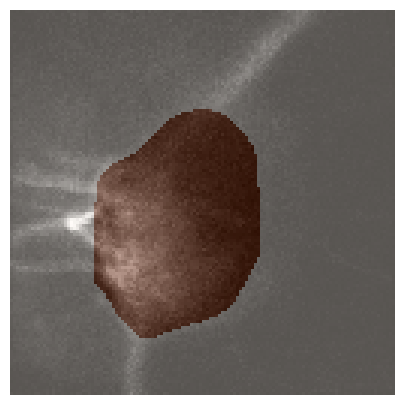

In [23]:
mask = viewer.layers["mask"].data
viewer.close()
if not exists(sep.join([dirName,'mask_3d.npy'])):
    np.save(sep.join([dirName,'mask_3d.npy']), mask.data)
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(refImg,cmap='Greys_r',origin='upper')
ax.axis('off');
ax.imshow(mask.data, cmap='Oranges', alpha=0.35)
fig.savefig(saveDir+sep+'mask_3d.pdf')

In [24]:
dffROI = dffStack[:,mask>0].mean(axis=1)

In [25]:
roiDf = pd.DataFrame(data = dffROI, columns = ['ROI'])
roiDf['time [s]'] = dffXarray['volumes [s]'].values

In [27]:
expMetadata = {
    'tiffilename': tifffileName,
    'genotype': genotype,
    'flyid': flyID,
    'trial':trial,
    'condition':'test',
    'roitype': "corr",
    'brainregion': region
}

imgTS_corrroi = imp.imagingTimeseries(
    imgMetadata = basicMetadat,
    expMetadata = expMetadata,
    refImage = refImg, 
    dffStack = dffXarray, 
    F0stack = F0Xarray,
    roitype = "corr",
    roiMask = mask, 
    roiDFF = roiDf
)


In [23]:
min_frame_index = 1
temp_var = np.array(playback.variables)
var = temp_var[0]

#Checks for frames dropped by Unity
range_to_check = list(range(min_frame_index, posDf['frame'].iloc[-1].astype(int)))
unity_frames = pd.Series([value in posDf['frame'].values for value in range_to_check], index=range_to_check)
unity_dropped_frames = unity_frames[~unity_frames].index

#Checks for frames dropped during video generation
range_to_check = list(range(min_frame_index, posDf['frame'].iloc[-1].astype(int)))
playback_frames = pd.Series([value in playback[var].frames for value in range_to_check], index=range_to_check)
playback_dropped_frames = unity_frames[~playback_frames].index

#Checks for frames dropped only during video generation. These should be regenerated
playback_in_unity = playback_dropped_frames.isin(unity_dropped_frames)
unique_playback_dropped_frames = playback_dropped_frames[~playback_in_unity]
unity_in_playback = unity_dropped_frames.isin(playback_dropped_frames)
unique_unity_dropped_frames = unity_dropped_frames[~unity_in_playback]

temp = alignDf['Unity Index'].isin(unique_playback_dropped_frames)
alignDf['Unity Index'].iloc[temp[temp].index] = np.nan

if int(len(playback[var].frames)) + len(unique_playback_dropped_frames) != len(posDf) or len(unique_unity_dropped_frames)>0:
    print("Unity to playback alignment failed!")
else:
    print("All playback dropped frames found. " + str(len(unique_playback_dropped_frames)) + " frames dropped.")

All playback dropped frames found. 17 frames dropped.


In [27]:
playback_dropped_frames

Index([    1,     2,     4,  1095,  1302,  1525,  2551,  2933,  2950,  2962,
        2976,  2998,  3037,  3137,  3152,  3159,  3367,  3607,  6967,  7207,
       10568, 10809, 14170, 14411, 17772, 18013, 21374, 21615, 24976, 25217,
       28585, 28849, 32210, 32451, 35812, 36053, 39414, 39655, 43016, 43257,
       46618, 46859, 47302, 50220, 50461, 53822, 54063, 57424, 57665, 61026,
       61266, 64615, 64855, 68204, 68444, 71793, 72033, 75382, 75622],
      dtype='int64')

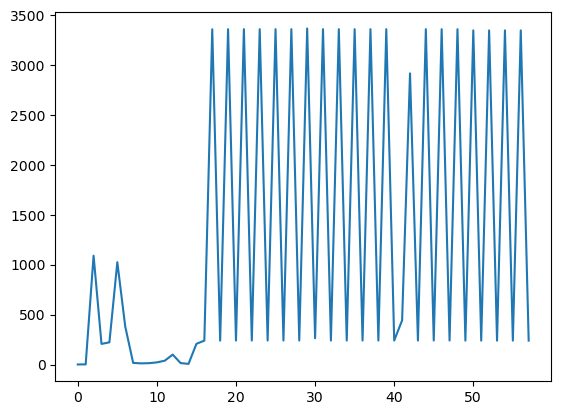

In [28]:
plt.plot(np.diff(playback_dropped_frames))

In [167]:
# Specify the directory and file name
posDf_path = sep.join([preprocDir, 'posDf.csv'])
wsDf_path = sep.join([preprocDir, 'wsDf.csv'])
alignDf_path = sep.join([preprocDir, 'alignDf.csv'])

# Save DataFrame to CSV
posDf.to_csv(posDf_path, index=False)
alignDf.to_csv(alignDf_path, index=False)

In [30]:
viewer = napari.Viewer()
viewer.add_image(playback[var], name='Movie', colormap='gray', scale = [-1, 1])
napari.run()

In [187]:
posDf['frame'].iloc[-1]

77346.0